In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import warnings
import torch
import numpy as np
import random

warnings.filterwarnings("ignore")

sys.path.append("../")


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed = 42
fix_seed(seed)

In [2]:
from FL_utils import *
from FL_evaluation import *

from FL_model import create_clf_head, local_clf_train, aggregate_weights, federated_clf_training

2024-01-17 14:45:36.996844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 14:45:37.646139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-17 14:45:37.646202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-17 14:45:37.646208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
mimic_dir = r'/media/nghia/DATA/DATA/MIMICIII_Grouped'

exclude_var_list = ['icustay_id', 'label_death_icu']

train_data_mimic, train_target_mimic = get_data(mimic_dir, 'train_24h(min24h).csv',
                                                exclude_var_list=exclude_var_list, outcome_var='label_death_icu')
test_data_mimic, test_target_mimic = get_data(mimic_dir, 'test_24h(min24h).csv',
                                                exclude_var_list=exclude_var_list, outcome_var='label_death_icu')

train_data_mimic.shape, train_target_mimic.shape

((14624, 23), (14624,))

In [4]:
train_data_mimic_list = []
train_target_mimic_list = []
num_clients = 9

for i in range(num_clients):
    train_data_mimic_list.append(train_data_mimic.iloc[int(i*len(train_data_mimic)/num_clients):int((i+1)*len(train_data_mimic)/num_clients)])
    train_target_mimic_list.append(train_target_mimic.iloc[int(i*len(train_target_mimic)/num_clients):int((i+1)*len(train_target_mimic)/num_clients)])

for i in range(num_clients):
    globals()[f'client_data_{i}'] = pd.DataFrame(train_data_mimic_list[i])
    globals()[f'client_target_{i}'] = pd.DataFrame(train_target_mimic_list[i])

client_data_0.shape, client_target_0.shape

((1624, 23), (1624, 1))

In [5]:
input_shape = (23,)
latent_dim = 16
hidden_units = [128, 64, 32]
epsilon = 1e-7
num_rounds = 10
weight_dir = "weights_avg_9Clients"

client_data_list = [client_data_0, client_data_1, client_data_2, client_data_3, client_data_4,
                    client_data_5, client_data_6, client_data_7, client_data_8]
client_target_list = [client_target_0, client_target_1, client_target_2, client_target_3, client_target_4,
                      client_target_5, client_target_6, client_target_7, client_target_8]

In [6]:
global_clf = federated_clf_training(num_rounds, create_clf_head(input_shape), client_data_list, client_target_list, weight_dir, 32, 10)

Starting training round 0
Client 0 training
Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
 1/51 [..............................] - ETA: 1:05 - loss: 125.6735 - accuracy: 0.0625 - f1_metric: 0.0074 - precision_metric: 0.0039 - recall_metric: 0.0625

2024-01-17 14:45:41.034483: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-17 14:45:41.035420: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-17 14:45:41.035429: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-01-17 14:45:41.084279: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptx

51/51 [==============================] - 2s 6ms/step - loss: 86.7605 - accuracy: 0.0690 - f1_metric: 0.0462 - precision_metric: 0.3519 - recall_metric: 0.0692
Epoch 2/10
51/51 [==============================] - 0s 6ms/step - loss: 24.7788 - accuracy: 0.3695 - f1_metric: 0.4731 - precision_metric: 0.9013 - recall_metric: 0.3707
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 6.7032 - accuracy: 0.7309 - f1_metric: 0.8038 - precision_metric: 0.9131 - recall_metric: 0.7320
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 4.1444 - accuracy: 0.8276 - f1_metric: 0.8640 - precision_metric: 0.9082 - recall_metric: 0.8282
Epoch 5/10
51/51 [==============================] - 0s 6ms/step - loss: 3.2452 - accuracy: 0.8713 - f1_metric: 0.8912 - precision_metric: 0.9182 - recall_metric: 0.8711
Epoch 6/10
51/51 [==============================] - 0s 6ms/step - loss: 3.1288 - accuracy: 0.8916 - f1_metric: 0.9000 - precision_metric: 0.9126 - recall_metric: 0.

In [7]:
y_pred_global, y_label_global = get_predictions(global_clf, test_data_mimic)

evaluation(test_target_mimic, y_label_global, y_pred_global)

115/115 [==============================] - 0s 606us/step
Accuracy:  0.9559748427672956
Precision:  0.9138879000039555
Recall:  0.9559748427672956
F1 score:  0.9344577241198002
AUC:  0.8205322498116747
Average precision score:  0.2434603593706358


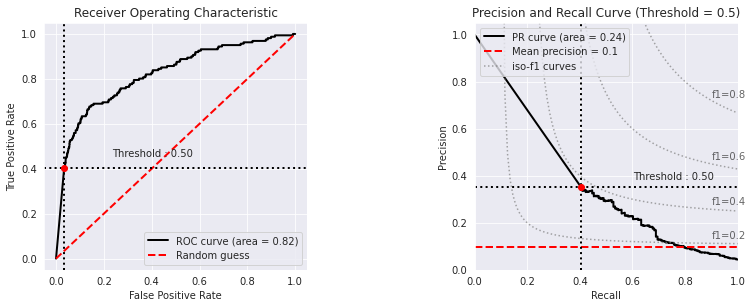

f1 score 0.1769:
f2 score 0.3358:
precision 0.9139:
recall 0.9560:
AUPRC 0.3736:
AUROC 0.8205:
Acc 0.9560:
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3496
           1       0.00      0.00      0.00       161

    accuracy                           0.96      3657
   macro avg       0.48      0.50      0.49      3657
weighted avg       0.91      0.96      0.93      3657



In [8]:
bnr_rp(test_target_mimic, y_pred_global, y_label_global, labels=[0, 1])